In [ ]:
!pip install optuna
!pip install scikit-optimize lightgbm catboost xgboost
!pip install dask[dataframe] -- upgrade
!pip install autogluon

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna.samplers import TPESampler

from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.common import space

from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_auc_score
from sklearn.base import clone
from scipy.special import logit
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier, plot_importance
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from autogluon.features.generators import AutoMLPipelineFeatureGenerator

from ray import tune
from imblearn.over_sampling import SMOTE


from sklearn.model_selection import cross_val_score, KFold
from skopt import BayesSearchCV

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Here is the differents steps :

- Loading of the data (the train and test table)
- Description of the tables
- Feature Engineering
- AutoGluon to find the best models
- Optuna to find the best hyperparameters

In [ ]:
## Settings to change

target = "loan_status"
time_limit_first_model = 60*1
time_limit_HP = 60*60
n_folds = 5
seed = 14*27*151

In [ ]:
## Import the data

train = pd.read_csv("/train.csv", sep=",",encoding="ISO-8859-1")
test = pd.read_csv("/test.csv", sep=",",encoding="ISO-8859-1")

In [ ]:
train.head()

Function :

Description of the table :

In [ ]:
train_encode = AutoMLPipelineFeatureGenerator().fit_transform(X=train)
test_encode = AutoMLPipelineFeatureGenerator().fit_transform(X=test)
train_encode.head()

In [ ]:
##faire deux cate : les valeurs et les categories
##pour les valeurs, histogramme
##pour les categories, repartition selon la target

In [ ]:
train_encode.hist(figsize=(12, 10), color='skyblue', edgecolor='black')
plt.gcf().set_facecolor('#36454F')
plt.tight_layout()
plt.show()

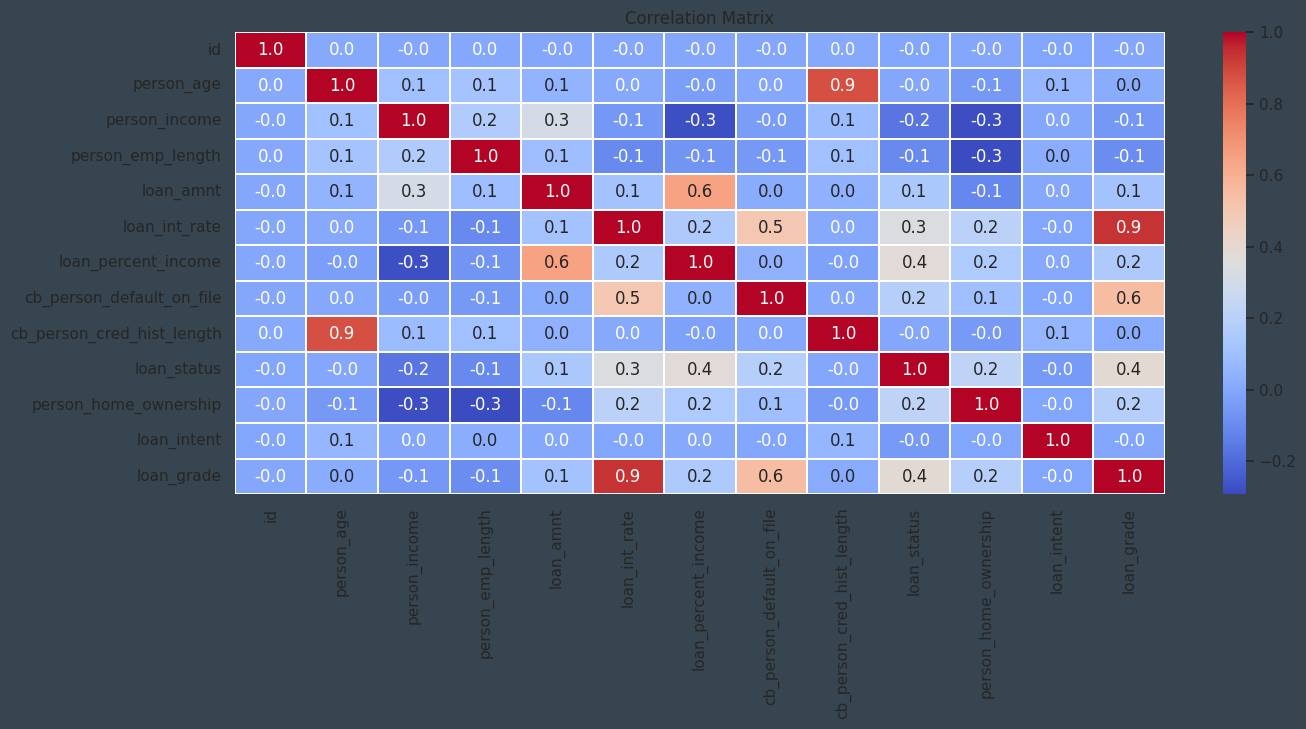

In [ ]:
correlation_matrix = train_encode.corr()
plt.figure(figsize=(15, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.2)
plt.gcf().set_facecolor('#36454F')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
correlation_matrix[target].sort_values(ascending=False)

,loan_status
loan_status,1.000000
loan_grade,0.385908
loan_percent_income,0.378280
loan_int_rate,0.338948
person_home_ownership,0.220167
cb_person_default_on_file,0.186962
loan_amnt,0.144982
person_age,-0.001130
cb_person_cred_hist_length,-0.003030
id,-0.008138


Feature engineering part :

In [ ]:
## Regarder les outliers pour chaque Loan Intent en terme de montant
## Voir si colinearite entre loan grade et les autres variables
## Checker en ligne pour voir les variables qui influent le plus
## Voir pour faire de l'oversampling si jamais il y a pas assez de 0 ou de 1

In [ ]:
variables_with_missing_values_50 = [
    var for var in train.columns if train[var].isnull().sum() > len(train)/2
]

train = train.drop(columns=variables_with_missing_values_50)
print(f"Variables with a lot of missing values: {variables_with_missing_values_50}")

# Find variables with missing values
variables_with_missing_values = [
    var for var in train.columns if train[var].isnull().sum() > 0
]

print(f"Variables with missing values: {variables_with_missing_values}")

Variables with a lot of missing values: []
Variables with missing values: []


In [ ]:
## OverSampling the data if unbalanced :

plt.figure(figsize=(4, 2))
sns.countplot(x=target, data=train_encode)
plt.xlabel(target)
plt.ylabel('Count')
plt.show()

In [ ]:
run = 0

if run==1:
  # Apply SMOTE to the specified class
  smote = SMOTE(random_state=seed)
  X_resampled, y_resampled = smote.fit_resample(train_encode.drop(columns=target), train_encode[target])

  X_resampled_df = pd.DataFrame(X_resampled, columns=train_encode.drop(columns=target).columns)
  train_encode = pd.concat([X_resampled_df, y_resampled], axis=1)

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x=target, data=train_encode)
plt.xlabel(target)
plt.ylabel('Count')
plt.show()

Choice of the model :

In [ ]:
## First, we will use AutoGluon to find the best models

predictor = TabularPredictor(label=target, eval_metric='roc_auc').fit(
    train_encode, time_limit=time_limit_first_model, presets='good_quality',num_gpus=1)

In [ ]:
#Here is the ones availables :
## https://auto.gluon.ai/dev/api/autogluon.tabular.models.html

##'NN_TORCH': Neural Network TensorFlow
##'GBM': GBM Model
##'CAT': Catboost
##'XGB': XGBoost
##'FASTAI': Neural Network for Tabular data
##'RF': Random Forest Model
##'XT': Extra Tree model
##'KNN' K Nearest Neighbors

In [ ]:
leaderboard = predictor.leaderboard(silent=True)
leaderboard

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT_BAG_L1,0.986898,roc_auc,1.068982,31.237909,1.068982,31.237909,1,False,1
1,WeightedEnsemble_L2,0.986898,roc_auc,1.093451,31.261280,0.024468,0.023371,2,False,2
2,WeightedEnsemble_L3,0.986898,roc_auc,1.101887,31.270166,0.032905,0.032257,3,False,3
3,WeightedEnsemble_L3_FULL,NaN,roc_auc,NaN,2.040729,NaN,0.032257,3,True,6
4,WeightedEnsemble_L2_FULL,NaN,roc_auc,NaN,2.031843,NaN,0.023371,2,True,5
5,LightGBMXT_BAG_L1_FULL,NaN,roc_auc,NaN,2.008472,NaN,2.008472,1,True,4


In [ ]:
 # Impute missing values (only for original dataset)

trainFT = train.copy()

categorical_columns = trainFT.select_dtypes(include=["object"]).columns.tolist()

# Convert categorical columns to 'category' type
trainFT[categorical_columns] = trainFT[categorical_columns].astype(str).astype("category")

encoder = OrdinalEncoder()
trainFT[categorical_columns] = encoder.fit_transform(trainFT[categorical_columns])

# Divide data into X and y sets
X = trainFT.drop(target, axis=1)
y = trainFT[target]

In [ ]:
# Define the search space for hyperparameters
search_spaces = {
    'GBM': {
        'learning_rate': (0.01, 0.3),
        'num_leaves': (31, 100),
        'min_child_samples': (1, 10),
        'max_depth': (1, 10)
    },
    'CAT': {
        'learning_rate': (0.01, 0.3),
        'depth': (1, 10),
        'l2_leaf_reg': (1, 10),
        'iterations': (100, 1000)
    },
    'XGB': {
        'learning_rate': (0.01, 0.3),
        'max_depth': (1, 10),
        'n_estimators': (100, 1000),
        'min_child_weight': (1, 10)
    }
}

# Define the models
models = {
    'GBM': LGBMClassifier(),
    'CAT': CatBoostClassifier(),
    'XGB': XGBClassifier()
}

# Define the cross-validation strategy
cv = StratifiedKFold(n_folds, shuffle=True,
                        random_state=seed)

dico = {}

# Define the search for the best hyperparameters
for model_name, model in models.items():
    search = BayesSearchCV(
        model,
        search_spaces[model_name],
        n_iter=10,
        cv=cv,
        random_state=seed
    )
    search.fit(X, y)
    dico[model_name] = search.best_params_



In [ ]:
## display the hyperparameters if you need to re-run it :

dico

{'GBM': OrderedDict([('learning_rate', 0.0787074981016308),
              ('max_depth', 8),
              ('min_child_samples', 8),
              ('num_leaves', 58)]),
 'CAT': OrderedDict([('depth', 10),
              ('iterations', 967),
              ('l2_leaf_reg', 9),
              ('learning_rate', 0.01935011258954552)]),
 'XGB': OrderedDict([('learning_rate', 0.0787074981016308),
              ('max_depth', 8),
              ('min_child_weight', 8),
              ('n_estimators', 451)])}

In [ ]:
predictor_ensemble = TabularPredictor(label=target, eval_metric='roc_auc').fit(
    train_encode, time_limit=time_limit_HP, presets='best_quality', hyperparameters=dico,
    num_bag_folds=5, num_stack_levels=2, num_gpus=1)

leaderboard = predictor_ensemble.leaderboard(silent=True)

In [ ]:
top_models = list(leaderboard['model'].head(3))

for model in top_models:
  predictor_ensemble.refit_full(model=model)

top_models

In [ ]:
## lAST MODEL, the one to predict them all

predictions = predictor_ensemble.predict(test_encode)
predictions

In [ ]:
submissions = pd.DataFrame({
    'id' : test['id'],
    'loan_status' : predictions
})

submissions.to_csv('/submission.csv', index=False)

In [ ]:
predictor_ensemble.feature_importance(train)